## NX-414: Brain-like computation and intelligence
Notebook prepared by Alessandro Marin Vargas

In [1]:
SKIP = True

# Week 6 - Mini project (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. In the data we provided you, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

### Deadline for Mini-Project Submission: May 7, 2025

You are required to submit your mini-projects by midnight on 07/05/25. Please upload a .zip file to Moodle containing your code, along with the following specific components:

- One-Page Report (Report.pdf): This should detail your investigative process and include:
    - A comparison table of models. This should cover linear regression from stimuli, both trained and random task-driven models, data-driven models, and your best-performing model.
    - A figure illustrating the variation in neural prediction across different layers of a task-driven model.
    - Your exploration to develop the most effective model at predicting IT neural activity
- Example Script/Notebook: Please provide a script (test.py) or a notebook (test.ipynb) demonstrating how your best model performs on the validation set. This should serve as an example of the model's usage.

In [2]:
if not SKIP:
    import sys
    !{sys.executable} -m pip install gdown h5py

In [3]:
from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
import gdown

if not SKIP:
    url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
    output = "IT_data.h5"
    gdown.download(url, output, quiet=False, fuzzy=True)


### Load the data

In [4]:
path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)


In [5]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The train dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The train dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224


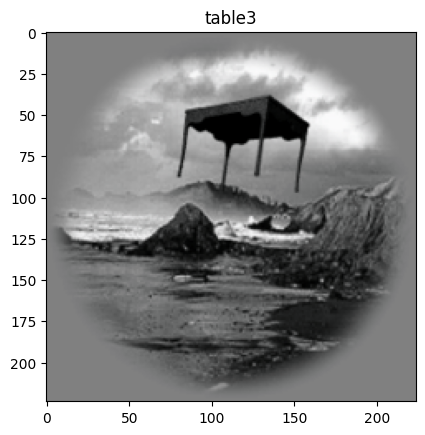

In [6]:
stim_idx = 1

visualize_img(stimulus_train,objects_train,stim_idx)

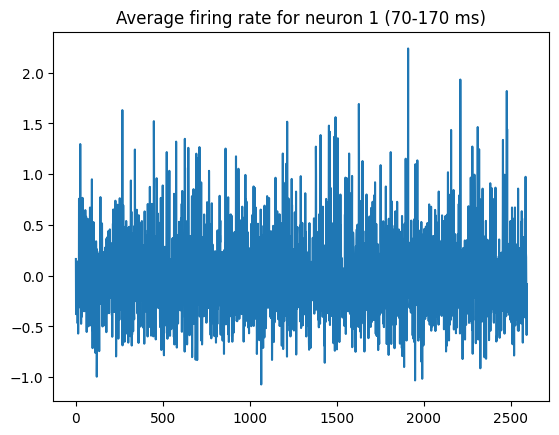

In [7]:
neuron_idx = 1

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(spikes_train[:,neuron_idx])

## Part 1: Predict the neural activity from pixels

##### Develop a linear regression model that predict the neural activity from pixels.
You can try out different types of linear regression (ridge, least-square regression)

In [8]:
print(f"Input: images of shape {stimulus_train.shape}")
print(f"Output: neurons spikes of shape {spikes_train.shape}")

print(f'Train: {stimulus_train.shape[0]}')
print(f'Validation: {stimulus_val.shape[0]}')

Input: images of shape (2592, 3, 224, 224)
Output: neurons spikes of shape (2592, 168)
Train: 2592
Validation: 288


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LinearRegression

X_train = stimulus_train.reshape(stimulus_train.shape[0], -1)
X_val = stimulus_val.reshape(stimulus_val.shape[0], -1)
predictions = {}
print(f"X shape: train {X_train.shape} - val {X_val.shape}")

X shape: train (2592, 150528) - val (288, 150528)


In [10]:
# 1. Ridge Regression Model
ridge = Ridge()
ridge.fit(X_train, spikes_train)

# Predictions
predictions['ridge'] = ridge.predict(X_val)

/Users/arthurchansel/anaconda3/envs/NX-414/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:252: LinAlgWarning: Ill-conditioned matrix (rcond=5.12002e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


In [11]:
# 2. Least Squares Regression Model
ls_model = LinearRegression()
ls_model.fit(X_train, spikes_train)

# Predictions
predictions['ls'] = ls_model.predict(X_val)

##### Evaluate your prediction (Check both the correlation and explained variance for each neuron). Plot the distribution for the explained variance across neurons.

In [12]:
from sklearn.metrics import explained_variance_score
from scipy.stats import pearsonr
from typing import List

def evaluation_metrics(predictions, y_true, metrics, keys: List[str]=None):
    if keys:
        predictions = {key: predictions[key] for key in keys}
    fig, axs = plt.subplots(len(predictions), 2, figsize=(10, 2*len(predictions)))
    axs = axs.ravel()

    # For each prediction
    for idx, (key, pred) in enumerate(predictions.items()):
        ev = explained_variance_score(y_true, pred, multioutput='raw_values')
        corr = np.array([pearsonr(x,y)[0] for (x,y) in zip(pred.T, y_true.T)])
        print(f"-- {key} --")
        print("Mean EV:", ev.mean())
        print("Mean Pearson correlation:", corr.mean())
        metrics[key] = {"ev": ev.mean().item(), "corr": corr.mean().item()}

        # Explained Variance
        axs[2*idx+0].hist(ev, bins=30, edgecolor='black', alpha=0.7)
        axs[2*idx+0].set_title(f'{key} - EV across neurons')
        axs[2*idx+0].set_xlabel('Explained Variance')
        axs[2*idx+0].set_ylabel('Number of Neurons')

        # Correlation
        axs[2*idx+1].hist(corr, bins=30, edgecolor='black', alpha=0.7)
        axs[2*idx+1].set_title(f'{key} - Correlation across neurons')
        axs[2*idx+1].set_xlabel('Correlation Coefficient')
        axs[2*idx+1].set_ylabel('Number of Neurons')

    # Align the scales
    for scale in [axs[::2], axs[1::2]]:
        min_val = min([ax.get_xlim()[0] for ax in scale])
        max_val = max([ax.get_xlim()[1] for ax in scale])
        for ax in scale:
            ax.set_xlim(min_val, max_val)

    plt.tight_layout()
    plt.show()

-- ridge --
Mean EV: -1.1574523
Mean Pearson correlation: 0.14667943
-- ls --
Mean EV: -0.033401232
Mean Pearson correlation: 0.21750107


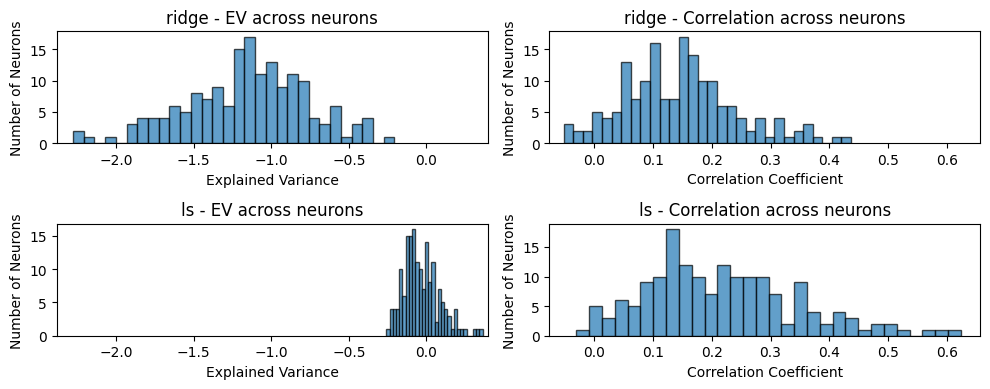

In [13]:
metrics = {}
evaluation_metrics(predictions, spikes_val, metrics)

From this first naive approach, LS outperforms Ridge. However, it is still not a good estimator.

##### Predicting from pixels is very hard and the model is likely to overfit. An image is very high-dimensional, try to retain the corresponding 1000 PCs and use them to predict the neural activity. 

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1000)
X_train_reduced = pca.fit_transform(X_train)
X_val_reduced = pca.transform(X_val)

In [15]:
# 1. Ridge Regression Model
ridge = Ridge()
ridge.fit(X_train_reduced, spikes_train)

# Predictions
predictions['pca_ridge'] = ridge.predict(X_val_reduced)

In [16]:
# 2. Least Squares Regression Model
ls_model = LinearRegression()
ls_model.fit(X_train_reduced, spikes_train)

# Predictions
predictions['pca_ls'] = ls_model.predict(X_val_reduced)

-- ridge --
Mean EV: -1.1574523
Mean Pearson correlation: 0.14667943
-- pca_ridge --
Mean EV: -0.0807578
Mean Pearson correlation: 0.21780886
-- ls --
Mean EV: -0.033401232
Mean Pearson correlation: 0.21750107
-- pca_ls --
Mean EV: -0.08077618
Mean Pearson correlation: 0.2178056


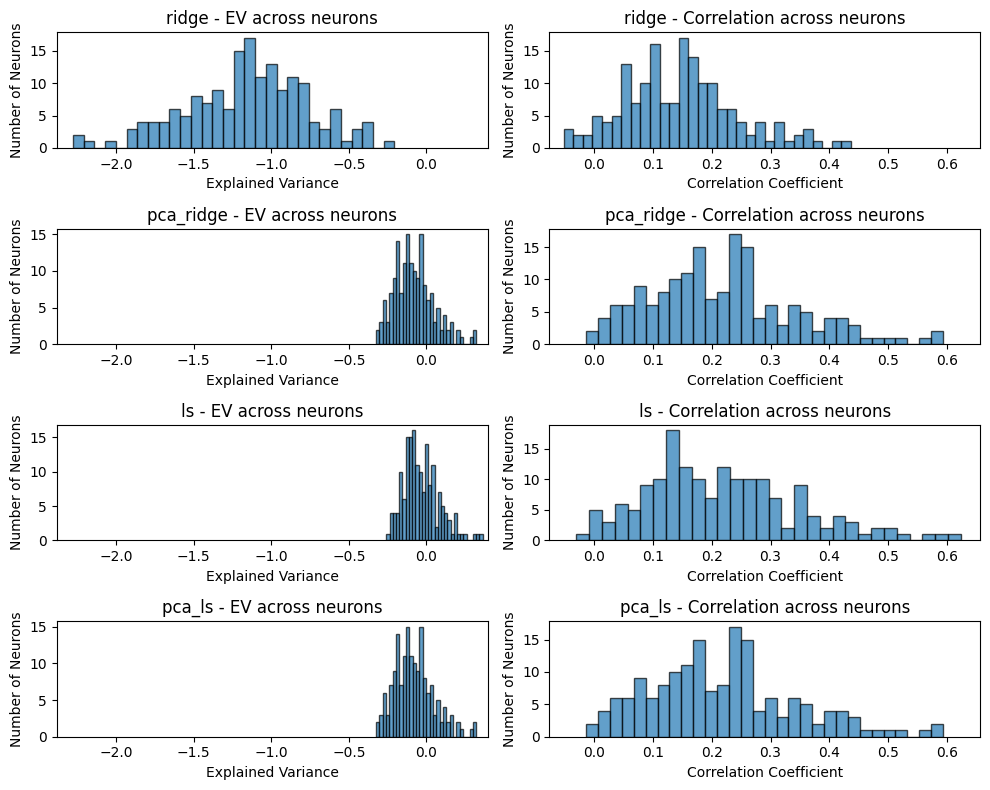

In [17]:
evaluation_metrics(predictions, spikes_val, metrics, ['ridge', 'pca_ridge', 'ls', 'pca_ls'])

PCA improves Ridge but not LS. But these estimators still provide not satisfying results.

##### Can we improve the prediction? Using the ridge regression, find the best parameter with cross-fold validation (remember to split the data keeping the same distribution of classes between the train and validation set). Does it get better?

Best alpha: 1e+06
-- pca_ridge --
Mean EV: -0.0807578
Mean Pearson correlation: 0.21780886
-- pca_best_ridge --
Mean EV: 0.087315366
Mean Pearson correlation: 0.28271967


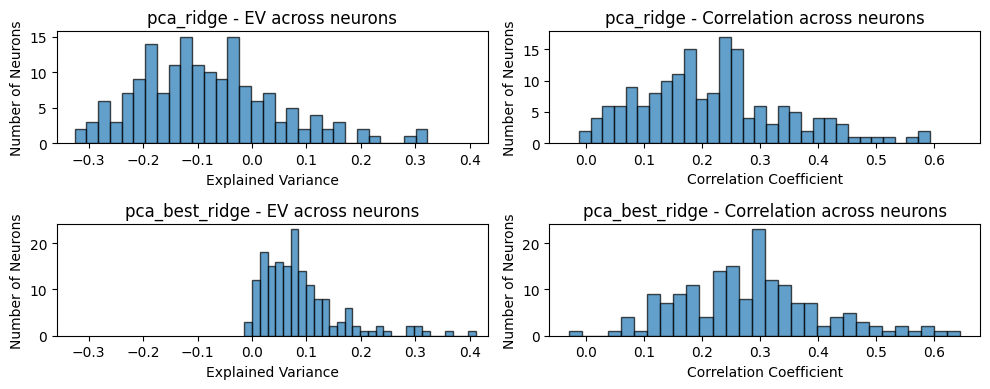

In [18]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Ridge Model
ridge = Ridge()

# Classes
label_encoder = LabelEncoder()
y_classes = label_encoder.fit_transform(objects_train)

# Cross validation
param_grid = {'alpha': np.logspace(-3, 10, 14)}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_ridge = GridSearchCV(ridge, param_grid, cv=cv.split(X_train_reduced, y_classes), scoring='r2', n_jobs=-1) # scoring: 'r2', 'explained_variance', 'neg_mean_squared_error'
cv_ridge.fit(X_train_reduced, spikes_train)

# Best model
best_ridge = cv_ridge.best_estimator_
best_alpha = cv_ridge.best_params_['alpha']
print(f"Best alpha: {best_alpha:.0e}")

predictions[f"pca_best_ridge"] = best_ridge.predict(X_val_reduced)
evaluation_metrics(predictions, spikes_val, metrics, ['pca_ridge', 'pca_best_ridge'])

The Ridge estimator has been considerably improved by tuning its regularization parameter, alpha. The optimal value found was 1e6, selected from a logarithmic grid search ranging from 1e-3 to 1e10. However the predictions are still not good, and we need to try a new approach to get better results.

### Part 2: Predict the neural activity with the task-driven modeling approach

As you have seen in the class, the underlying hypothesis of task-driven modeling is that training the network to perform a relevant behavioral task makes the network to develop representations that resemble the ones of the biological brain. Let's test this hypothesis by loading a pre-trained ResNet50 model and use the activations of each layer to predict the neural activity. Follow these steps:

- Give as input to the network the stimuli and extract the corresponding activations of the following layers ['conv1','layer1','layer2','layer3','layer4','avgpool']
- Compute the 1000 PCs for each layer activation. (Careful that you don't want to store all activations together at the same time because it won't fit in the memory. Therefore, compute the activations and corresponding PCs for each layer and store only the computed PCs).
- Use the PCs of each layer to predict the neural activity using the linear regression models you developed before.
- Compute the goodness of fit using the correlation and explained variance metrics. Do you predict the neural activity better than before?
- Plot the distribution of explained variance with respect to the layer of the network (order them based on the depth). How does the neural activity changes across the model layers, can you make some statements about it?
- Compare the predictions that you obtained using one layer of the pretrained model and the one obtained using the same layer but from a randomly initialized model. Which network can better predict the neural activity and why?

In [19]:
# Dataloader

import torch
from torch.utils.data import Dataset, DataLoader

class SpikesDataset(Dataset):
    def __init__(self, stimuli, spikes):
        self.stimuli = torch.tensor(stimuli, dtype=torch.float32)
        self.spikes = torch.tensor(spikes, dtype=torch.float32)

    def __len__(self):
        return len(self.stimuli)

    def __getitem__(self, idx):
        stimulus = self.stimuli[idx]
        spike = self.spikes[idx]
        return stimulus, spike

train_dataset = SpikesDataset(stimulus_train, spikes_train)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataset = SpikesDataset(stimulus_val, spikes_val)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

# Display 1st batch shape
for stimuli_batch, spikes_batch in train_loader:
    print(f"Stimuli batch shape: {stimuli_batch.shape}")
    print(f"Spikes batch shape: {spikes_batch.shape}")
    break

Stimuli batch shape: torch.Size([8, 3, 224, 224])
Spikes batch shape: torch.Size([8, 168])


In [20]:
# 1. Extract layers activations for the stimuli
import os
import torch
import torch.nn as nn
import glob

def extract_activations(layer_name: str, dir: str, model, train: bool):
    # Setup forward hooks
    def get_activation(name):
        count = {'n': 0}
        def hook(model, input, output):
            fname = f"{dir}/{'train' if train else 'val'}_{name}_{count['n']}.pt"
            torch.save(output.detach().cpu(), fname)
            count['n'] += 1
        return hook

    # Setup model
    model.eval()
    layer = dict(model.named_modules())[layer_name]
    layer.register_forward_hook(get_activation(layer_name))

    # Forward pass
    with torch.no_grad():
        loader = train_loader if train else val_loader
        for stimuli_batch, spikes_batch in loader:
            _ = model(stimuli_batch)

In [21]:
# 2. Compute 1000 PCs, for each layer (one layer at a time)
from sklearn.decomposition import PCA

def load_activations(path, layer, train: bool):
    files = sorted(glob.glob(f"{path}/{'train' if train else 'val'}_{layer}_*.pt"))
    activations = []
    for f in files:
        batch = torch.load(f, weights_only=True)
        activations.append(batch.view(len(batch),-1).numpy())
        del batch
    activations = np.vstack(activations)
    return activations

def pcs_layer(activations_train, n_components=1000):
    pca = PCA(n_components=n_components)
    pcs = pca.fit_transform(activations_train)
    return pcs

In [22]:
# 3. Linear models to predict activity from PCs

def layer_predictions(train, val):
    ridge = Ridge(alpha=best_alpha)
    ridge.fit(train, spikes_train)
    return ridge.predict(val)

In [23]:
# Run the pipeline for all layers ~40min
import torchvision.models as models
from torchvision.models import ResNet50_Weights
from tqdm import tqdm

def pipeline(layer, dir, model):
    print("⚙️ Extract Activations train")
    extract_activations(layer, dir, model, True)
    print("📂 Load files train")
    activations_train = load_activations(dir, layer, True)
    print("⏳ PCs train")
    pca = PCA(n_components=1000)
    pcs_train = pca.fit_transform(activations_train)
    del activations_train
    print("⚙️ Extract Activations val")
    extract_activations(layer, dir, model, False)
    print("📂 Load files val")
    activations_val = load_activations(dir, layer, False)
    print("⏳ PCs val")
    pcs_val = pca.transform(activations_val)
    del activations_val
    print("🔮 Linear Predictions")
    predictions[layer] = layer_predictions(pcs_train, pcs_val)

device = "cpu"
layers = ['conv1','layer1','layer2','layer3','layer4','avgpool']
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2).to(device)

# Activations dir
tmp_dir = "tmp"
os.makedirs(tmp_dir, exist_ok=True)
# Reset old files
for f in os.listdir(tmp_dir):
    os.remove(os.path.join(tmp_dir, f))

# Run the pipeline
for i, layer in tqdm(enumerate(layers), total=len(layers), desc="Processing layers"):
    print(f"{layer} ({i+1}/{len(layers)})")
    pipeline(layer, tmp_dir, model)

/Users/arthurchansel/anaconda3/envs/NX-414/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/arthurchansel/anaconda3/envs/NX-414/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/arthurchansel/anaconda3/envs/NX-414/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/arthurchansel/anaconda3/envs/NX-414/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/arthurchansel/anaconda3/envs/NX-414/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/arthurchansel/anaconda3/envs/NX-414/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/arthurchansel/anaconda3/envs/NX-414/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you c

conv1 (1/6)
⚙️ Extract Activations train
📂 Load files train
⏳ PCs train
⚙️ Extract Activations val
📂 Load files val
⏳ PCs val


Processing layers:  17%|█▋        | 1/6 [11:25<57:08, 685.69s/it]

🔮 Linear Predictions
layer1 (2/6)
⚙️ Extract Activations train
📂 Load files train
⏳ PCs train
⚙️ Extract Activations val
📂 Load files val
⏳ PCs val


Processing layers:  33%|███▎      | 2/6 [23:31<47:18, 709.52s/it]

🔮 Linear Predictions
layer2 (3/6)
⚙️ Extract Activations train
📂 Load files train
⏳ PCs train
⚙️ Extract Activations val
📂 Load files val
⏳ PCs val


Processing layers:  50%|█████     | 3/6 [30:31<28:50, 576.99s/it]

🔮 Linear Predictions
layer3 (4/6)
⚙️ Extract Activations train
📂 Load files train
⏳ PCs train
⚙️ Extract Activations val
📂 Load files val
⏳ PCs val


Processing layers:  67%|██████▋   | 4/6 [35:53<15:52, 476.26s/it]

🔮 Linear Predictions
layer4 (5/6)
⚙️ Extract Activations train
📂 Load files train
⏳ PCs train
⚙️ Extract Activations val
📂 Load files val
⏳ PCs val


Processing layers:  83%|████████▎ | 5/6 [40:27<06:43, 403.41s/it]

🔮 Linear Predictions
avgpool (6/6)
⚙️ Extract Activations train
📂 Load files train
⏳ PCs train
⚙️ Extract Activations val


Processing layers: 100%|██████████| 6/6 [44:41<00:00, 446.94s/it]

📂 Load files val
⏳ PCs val
🔮 Linear Predictions


-- conv1 --
Mean EV: -0.09518963
Mean Pearson correlation: 0.009984104
-- layer1 --
Mean EV: -0.023212824
Mean Pearson correlation: -0.006093184
-- layer2 --
Mean EV: -0.012941562
Mean Pearson correlation: 0.009031221
-- layer3 --
Mean EV: -0.005224602
Mean Pearson correlation: 0.009055992
-- layer4 --
Mean EV: -0.0054853046
Mean Pearson correlation: -0.0079905735
-- avgpool --
Mean EV: -4.366466e-05
Mean Pearson correlation: -0.026254106


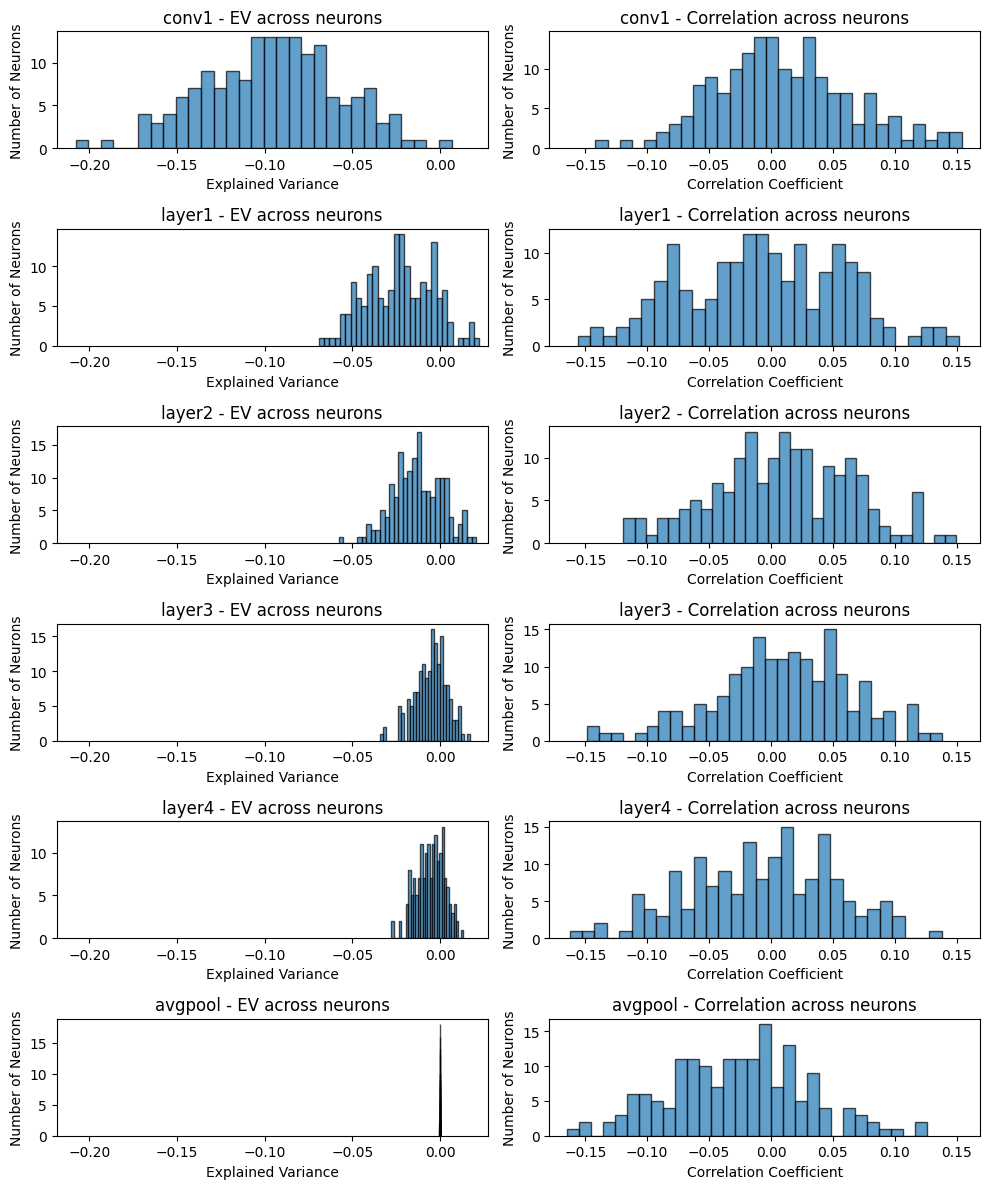

In [24]:
# 4. Metrics: correlation, EV / 5. EV distribution per layer
evaluation_metrics(predictions, spikes_val, metrics, layers)

In [28]:
import pandas as pd

metrics_df = pd.DataFrame.from_dict(metrics, orient='index')

print("Top EV:")
display(metrics_df.sort_values(by='ev', ascending=False))
print("\nTop Corr:")
display(metrics_df.sort_values(by='corr', ascending=False))

Top EV:


,ev,corr
pca_best_ridge,0.087315,0.282720
avgpool,-0.000044,-0.026254
layer3,-0.005225,0.009056
layer4,-0.005485,-0.007991
layer2,-0.012942,0.009031
layer1,-0.023213,-0.006093
ls,-0.033401,0.217501
pca_ridge,-0.080758,0.217809
pca_ls,-0.080776,0.217806
conv1,-0.095190,0.009984



Top Corr:


,ev,corr
pca_best_ridge,0.087315,0.282720
pca_ridge,-0.080758,0.217809
pca_ls,-0.080776,0.217806
ls,-0.033401,0.217501
ridge,-1.157452,0.146679
conv1,-0.095190,0.009984
layer3,-0.005225,0.009056
layer2,-0.012942,0.009031
layer1,-0.023213,-0.006093
layer4,-0.005485,-0.007991


The best layer is avgpool, however the previous results were better.

In [27]:
# 6. Compare random and resnet50 on 1st layer
# model = models.resnet50(weights=None).to(device)
# layer = "best_layer"

# # Activations dir
# tmp_dir = "tmp_random"
# os.makedirs(tmp_dir, exist_ok=True)
# # Reset old files
# for f in os.listdir(tmp_dir):
#     os.remove(os.path.join(tmp_dir, f))

# # Run the pipeline
# for i, layer in tqdm(enumerate(layers), total=len(layers), desc="Processing layers"):
#     print(f"{layer} ({i+1}/{len(layers)})")
#     pipeline(layer, tmp_dir, model)

# evaluation_metrics(predictions, spikes_val, metrics, ["conv1", "conv1_rnd"])